# Introduction

- Driver Age and Class of Motor Vehicle
- Driver Contributory Factors and Severity
- Where tourist goes, where it does not.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# from https://data.gov.hk/en-data/dataset/hk-immd-set5-statistics-daily-passenger-traffic/resource/e06a2a45-fe05-4eb4-9302-237d74343d52
dailyPassengerPath = "/content/drive/MyDrive/HKBU/ALL/statistics_on_daily_passenger_traffic_2021-2023.csv"
# from https://data.gov.hk/en-data/dataset/hk-td-tis_10-monthly-traffic-and-transport-digest
accidentData = "/content/drive/MyDrive/HKBU/ALL/accident-data-2017-2022/"
# from https://data.gov.hk/en-data/dataset/hk-td-tis_10-monthly-traffic-and-transport-digest/resource/3e1c47ab-fed4-4e69-bd22-e2523bca3266
maxiInvData = "/content/drive/MyDrive/HKBU/ALL/monthly taxi involvement.csv"

In [ ]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


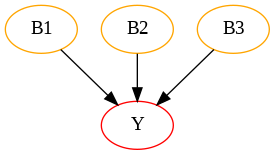

In [ ]:
import pygraphviz as pgv
from IPython.display import Image

# Create the Bayesian network graph
G = pgv.AGraph(directed=True)

# Define nodes
G.add_node("Y", shape="ellipse", label="Y", color="red", style="outline")
G.add_node("B1", shape="ellipse", label="B1", color="orange", style="outline")
G.add_node("B2", shape="ellipse", label="B2", color="orange", style="outline")
G.add_node("B3", shape="ellipse", label="B3", color="orange", style="outline")

# Connect the nodes
G.add_edge("B1", "Y") # Mainland Visitors
G.add_edge("B2", "Y") # Tourists
G.add_edge("B3", "Y") # Residents

# Render the graph to a file
output_file = "bayesian_network.png"
G.draw(output_file, format="png", prog="dot")

# Display the image
Image(output_file)


# 1.&nbsp;Get the airport arrivals

In [ ]:
LOST_LINES = []
try:
  with open(dailyPassengerPath, 'r', encoding="utf-8") as file:
      df = pd.read_csv(file)

      # Filter rows where control points is only Airport and Arrivals
      airport_arrival_rows = df[(df['Control Point'] == 'Airport') & (df['Arrival / Departure'] == 'Arrival')]

      # Create a new DataFrame with only the airport arrival rows
      airport_arrival_df = pd.DataFrame(airport_arrival_rows)

except Exception as y:
  LOST_LINES.append(y)

# New dataframe with only airport control points.
print(airport_arrival_df)
print("Number of lost lines: " + str(len(LOST_LINES)))

             Date Control Point Arrival / Departure  Hong Kong Residents  \
0      01-01-2021       Airport             Arrival                  341   
32     02-01-2021       Airport             Arrival                  363   
64     03-01-2021       Airport             Arrival                  880   
96     04-01-2021       Airport             Arrival                  445   
128    05-01-2021       Airport             Arrival                  534   
...           ...           ...                 ...                  ...   
32546  25-11-2023       Airport             Arrival                28072   
32576  26-11-2023       Airport             Arrival                36579   
32606  27-11-2023       Airport             Arrival                31648   
32636  28-11-2023       Airport             Arrival                28415   
32666  29-11-2023       Airport             Arrival                25547   

       Mainland Visitors  Other Visitors  Total  Unnamed: 7  
0                      0 

# 2.&nbsp;Get the airport data filtered according to visitors

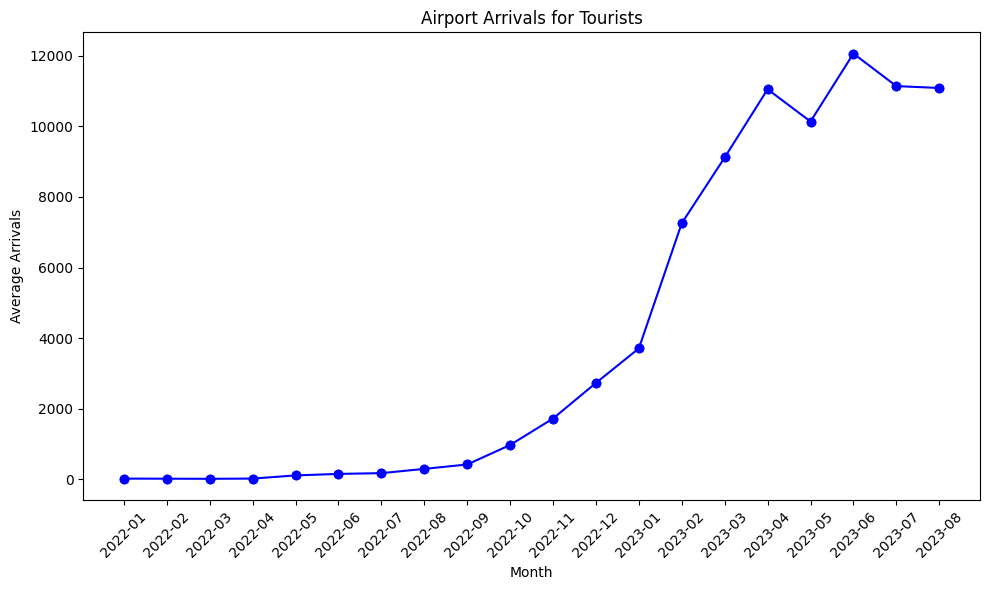

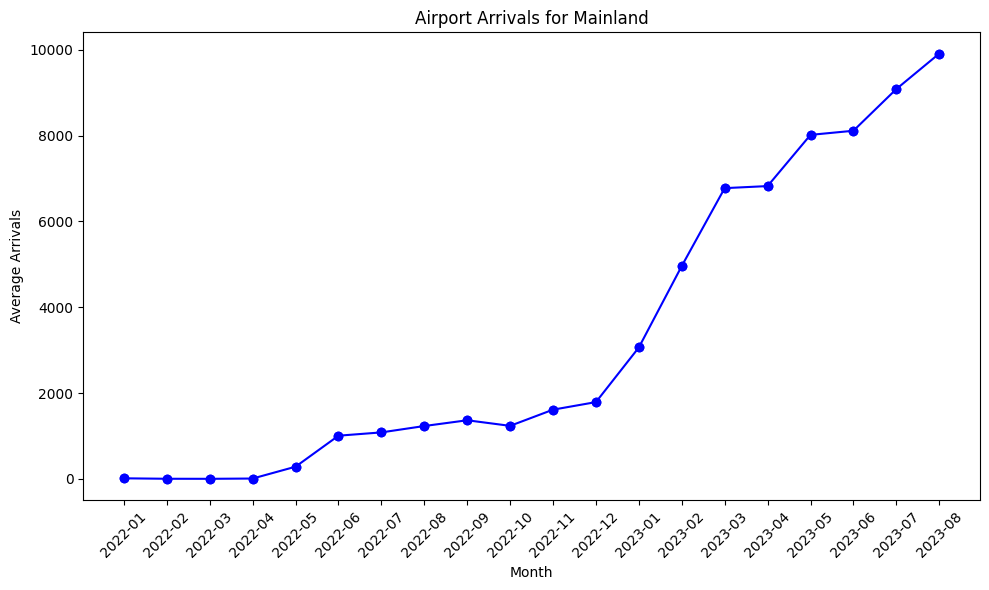

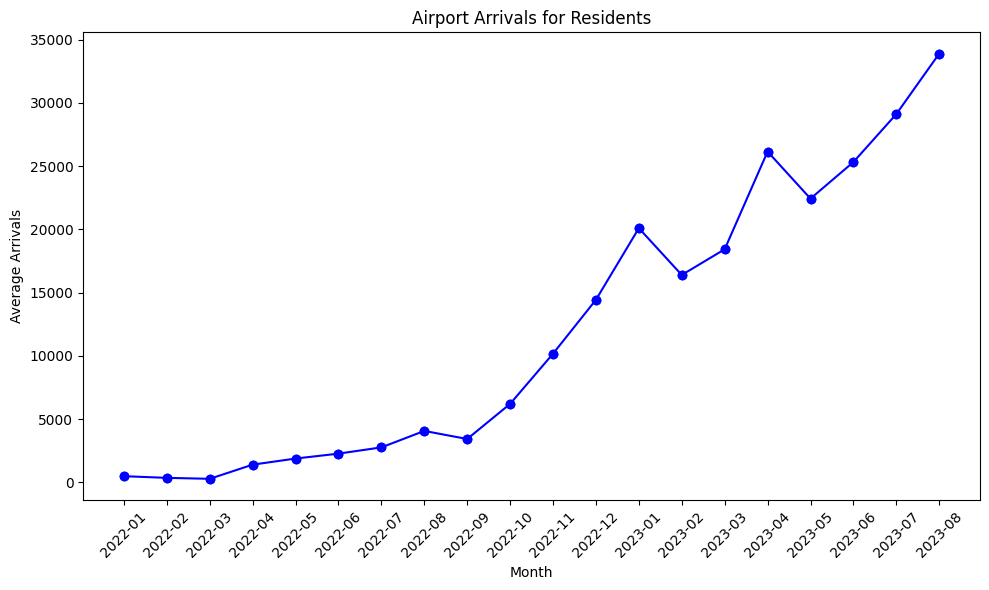

In [ ]:
# Convert date to datetime
airport_arrival_df['Date'] = pd.to_datetime(airport_arrival_df['Date'], format='%d-%m-%Y')

# Get as a month
airport_arrival_df['Month'] = airport_arrival_df['Date'].dt.to_period('M')

# filter_words = ["Hong Kong Residents", "Mainland Visitors", "Other Visitors"]

# Group by month and calculate the average arrivals
avg_arrivals_by_month_tourists = airport_arrival_df.groupby('Month')['Other Visitors'].mean().reset_index()
avg_arrivals_by_month_mainland = airport_arrival_df.groupby('Month')['Mainland Visitors'].mean().reset_index()
avg_arrivals_by_month_residents = airport_arrival_df.groupby('Month')['Hong Kong Residents'].mean().reset_index()

# Filter the values from 2022-01 to 2023-08
avg_arrivals_by_month_tourists = avg_arrivals_by_month_tourists[
    (avg_arrivals_by_month_tourists['Month'] > '2021-12-01') &
    (avg_arrivals_by_month_tourists['Month'] < '2023-09-01')
]

avg_arrivals_by_month_mainland = avg_arrivals_by_month_mainland[
    (avg_arrivals_by_month_mainland['Month'] > '2021-12-01') &
    (avg_arrivals_by_month_mainland['Month'] < '2023-09-01')
]

avg_arrivals_by_month_residents = avg_arrivals_by_month_residents[
    (avg_arrivals_by_month_residents['Month'] > '2021-12-01') &
    (avg_arrivals_by_month_residents['Month'] < '2023-09-01')
]

# Tourists
plt.figure(figsize=(10, 6))
plt.scatter(avg_arrivals_by_month_tourists['Month'].dt.strftime('%Y-%m'), avg_arrivals_by_month_tourists['Other Visitors'], color='blue')
plt.plot(avg_arrivals_by_month_tourists['Month'].dt.strftime('%Y-%m'), avg_arrivals_by_month_tourists['Other Visitors'], linestyle='-', marker='o', color='blue')
plt.title('Airport Arrivals for Tourists')
plt.xlabel('Month')
plt.ylabel('Average Arrivals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tourists_arrivals.pdf')
# Show the plot
plt.show()

# Mainland
plt.figure(figsize=(10, 6))
plt.scatter(avg_arrivals_by_month_mainland['Month'].dt.strftime('%Y-%m'), avg_arrivals_by_month_mainland['Mainland Visitors'], color='blue')
plt.plot(avg_arrivals_by_month_mainland['Month'].dt.strftime('%Y-%m'), avg_arrivals_by_month_mainland['Mainland Visitors'], linestyle='-', marker='o', color='blue')
plt.title('Airport Arrivals for Mainland')
plt.xlabel('Month')
plt.ylabel('Average Arrivals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mainland_arrivals.pdf')
# Show the plot
plt.show()

# Hong Kong Residents
plt.figure(figsize=(10, 6))
plt.scatter(avg_arrivals_by_month_residents['Month'].dt.strftime('%Y-%m'), avg_arrivals_by_month_residents['Hong Kong Residents'], color='blue')
plt.plot(avg_arrivals_by_month_residents['Month'].dt.strftime('%Y-%m'), avg_arrivals_by_month_residents['Hong Kong Residents'], linestyle='-', marker='o', color='blue')
plt.title('Airport Arrivals for Residents')
plt.xlabel('Month')
plt.ylabel('Average Arrivals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('residents_arrivals.pdf')
# Show the plot
plt.show()

# 3.&nbsp;Get the taxi involement data 2022-01 to 2023-08

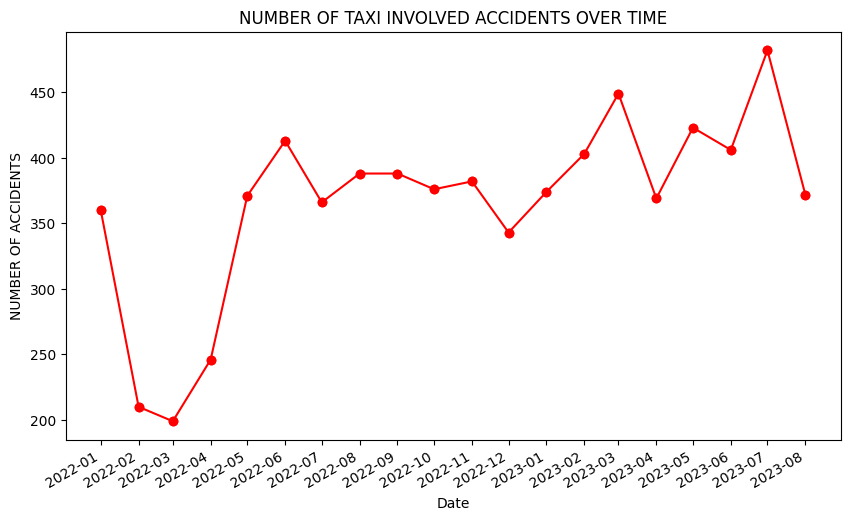

In [ ]:
filename = "/content/drive/MyDrive/HKBU/ALL/monthly taxi involvement.csv"

try:
    with open(filename, 'r', encoding='utf-8') as file:
        data = pd.read_csv(filename)

        # Convert YR_MTH to datetime format
        data['YR_MTH'] = pd.to_datetime(data['YR_MTH'], format='%Y%m')

        # Filter the data for rows where VEHICLE_CLASS_CODE is 3
        filtered_data = data[data['VEHICLE_CLASS_CODE'] == 3]

        # Filter the data to get only rows after '2022-01'
        filtered_df_taxi = filtered_data[filtered_data['YR_MTH'] > '2021-12-01']

        plt.figure(figsize=(10, 6))

        # Create the scatter plot with red dots
        plt.scatter(filtered_df_taxi['YR_MTH'], filtered_df_taxi['NO_VEHICLE'], color='red')

        # Connect the dots with a line
        plt.plot(filtered_df_taxi['YR_MTH'], filtered_df_taxi['NO_VEHICLE'], color='red', linestyle='-', marker='o')

        # Set labels and title
        plt.xlabel('Date')
        plt.ylabel('NUMBER OF ACCIDENTS')
        plt.title('NUMBER OF TAXI INVOLVED ACCIDENTS OVER TIME')

        # Format x-axis to show every month
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

        # Rotate x-axis labels for better readability
        plt.gcf().autofmt_xdate()

        plt.savefig('taxi_involvement.pdf')
        # Show the plot
        plt.show()
except Exception as e:
    print(e)


# 4. Correlation Analysis
- You could perform a correlation analysis to identify any relationships between the number of tourists (from different backgrounds) and the number of taxi accidents. If a strong correlation is found, it could suggest that an increase in tourists leads to an increase in accidents, or vice versa.

In [ ]:
import pandas as pd

# Convert YR_MTH to Month in First Data
filtered_df_taxi['Month'] = pd.to_datetime(filtered_df_taxi['YR_MTH']).dt.to_period('M')

# Merge datasets on the 'Month' column
merged_data = pd.merge(
                      filtered_df_taxi[['Month', 'NO_VEHICLE']],
                      avg_arrivals_by_month_mainland[['Month', 'Mainland Visitors']],
                       on='Month')

merged_data = pd.merge(merged_data,
                       avg_arrivals_by_month_residents[['Month', 'Hong Kong Residents']],
                       on='Month')

merged_data = pd.merge(merged_data,
                       avg_arrivals_by_month_tourists[['Month', 'Other Visitors']],
                       on='Month')

# Rename the 'Taxi Number' column in merged_data
merged_data = merged_data.rename(columns={'NO_VEHICLE': 'Taxi Number'})

merged_data.rename(columns={'Taxi Number': 'Taxi Number Accidents'}, inplace=True)

# Calculate correlation coefficients
correlation_matrix = merged_data[['Taxi Number Accidents', 'Mainland Visitors', 'Hong Kong Residents', 'Other Visitors']].corr()


# Display the correlation matrix
print(correlation_matrix)


                       Taxi Number Accidents  Mainland Visitors  \
Taxi Number Accidents               1.000000           0.588797   
Mainland Visitors                   0.588797           1.000000   
Hong Kong Residents                 0.536850           0.952173   
Other Visitors                      0.533777           0.980271   

                       Hong Kong Residents  Other Visitors  
Taxi Number Accidents             0.536850        0.533777  
Mainland Visitors                 0.952173        0.980271  
Hong Kong Residents               1.000000        0.945693  
Other Visitors                    0.945693        1.000000  


<ipython-input-27-cd2b8feda09a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_taxi['Month'] = pd.to_datetime(filtered_df_taxi['YR_MTH']).dt.to_period('M')


- Now, we will use heatmap to visulaize correlation matrix

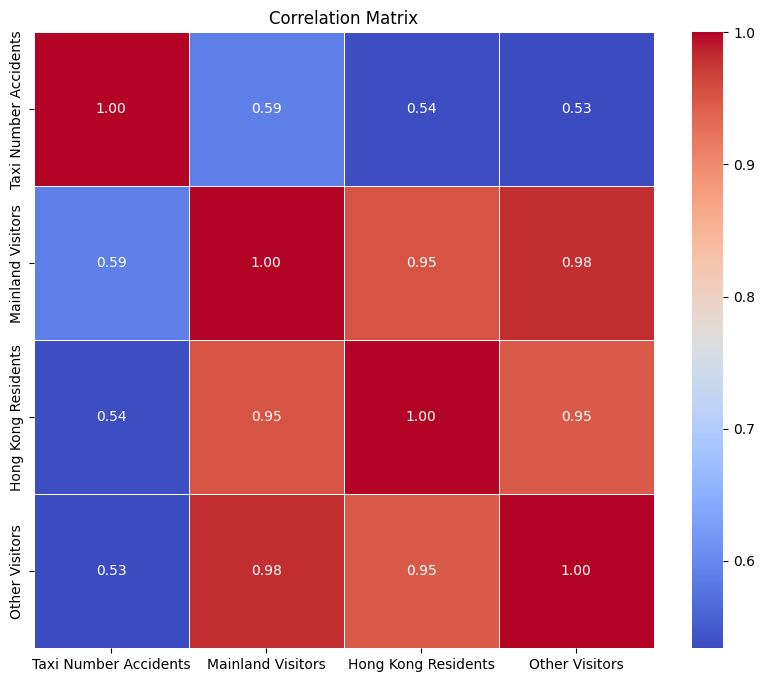

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add a title
plt.title('Correlation Matrix')

plt.savefig('heatmap.pdf')
# Show the plot
plt.show()

- Taxi Number Involved in Accident vs. Mainland Visitors (0.588797):

There is a moderate positive correlation (0.588797) between the number of taxi accidents ('Taxi Number') and the number of Mainland Visitors. This suggests that as the number of Mainland Visitors increases, the number of taxi accidents tends to increase, but the correlation is not extremely strong.

- Taxi Number Involved in Accident vs. Hong Kong Residents (0.536850):

There is a moderate positive correlation (0.536850) between the number of taxi accidents and the number of Hong Kong Residents. This implies that there is a tendency for an increase in taxi accidents as the number of Hong Kong Residents increases.

- Taxi Number Involved in Accident vs. Other Visitors (0.533777):

There is a moderate positive correlation (0.533777) between the number of taxi accidents and the number of Other Visitors. This suggests a similar pattern as observed with Mainland Visitors and Hong Kong Residents.

- Mainland Visitors vs. Hong Kong Residents (0.952173):

There is a very strong positive correlation (0.952173) between the number of Mainland Visitors and Hong Kong Residents. This indicates a close relationship where an increase in Mainland Visitors is highly correlated with an increase in Hong Kong Residents.

- Mainland Visitors vs. Other Visitors (0.980271):

There is a very strong positive correlation (0.980271) between the number of Mainland Visitors and Other Visitors. This implies a close relationship where an increase in Mainland Visitors is highly correlated with an increase in Other Visitors.

- Hong Kong Residents vs. Other Visitors (0.945693):

There is a very strong positive correlation (0.945693) between the number of Hong Kong Residents and Other Visitors. This indicates a close relationship where an increase in Hong Kong Residents is highly correlated with an increase in Other Visitors.

Overall, the correlation matrix provides insights into the relationships between taxi accidents and the number of visitors from different backgrounds. The strong correlations among the visitor categories suggest a potential common factor influencing their numbers. Keep in mind that correlation does not imply causation, so further analysis is needed to understand the underlying factors.

# 5. MCMC and Gibbs Sampling

In [ ]:
# Initialize the parameters
B1 = 0  # Mainland Visitors
B2 = 0  # Tourists
B3 = 0  # Residents

# Number of iterations
N_iter = 1000

# Placeholder for the samples
samples = np.zeros((N_iter, 3))  # Remove sigma_sq from the samples array
accidents = filtered_df_taxi['NO_VEHICLE']
mainland_visitors = avg_arrivals_by_month_mainland['Mainland Visitors']
tourists = avg_arrivals_by_month_tourists['Other Visitors']
locals = avg_arrivals_by_month_residents['Hong Kong Residents']

N = len(accidents)

for i in range(N_iter):
    # Sampling B1
    mean_B1 = (np.sum(accidents * mainland_visitors) - B2 * np.sum(mainland_visitors * tourists) - B3 * np.sum(mainland_visitors * locals)) / (np.sum(mainland_visitors**2) - B2 * np.sum(tourists * mainland_visitors) - B3 * np.sum(locals * mainland_visitors))
    B1 = np.random.normal(mean_B1, np.sqrt(1 / (np.sum(mainland_visitors**2) - B2 * np.sum(tourists * mainland_visitors) - B3 * np.sum(locals * mainland_visitors))))

    # Sampling B2
    mean_B2 = (np.sum(accidents * tourists) - B1 * np.sum(mainland_visitors * tourists) - B3 * np.sum(locals * tourists)) / (np.sum(tourists**2) - B1 * np.sum(mainland_visitors * tourists) - B3 * np.sum(locals * tourists))
    B2 = np.random.normal(mean_B2, np.sqrt(1 / (np.sum(tourists**2) - B1 * np.sum(mainland_visitors * tourists) - B3 * np.sum(locals * tourists))))

    # Sampling B3
    mean_B3 = (np.sum(accidents * locals) - B1 * np.sum(mainland_visitors * locals) - B2 * np.sum(tourists * locals)) / (np.sum(locals**2) - B1 * np.sum(mainland_visitors * locals) - B2 * np.sum(tourists * locals))
    B3 = np.random.normal(mean_B3, np.sqrt(1 / (np.sum(locals**2) - B1 * np.sum(mainland_visitors * locals) - B2 * np.sum(tourists * locals))))

    samples[i, :] = [B1, B2, B3]  # Remove sigma_sq from the samples array

# Burn-in period
burn_in = int(N_iter * 0.1)

# Posterior distributions
posterior_B1 = samples[burn_in:, 0]
posterior_B2 = samples[burn_in:, 1]
posterior_B3 = samples[burn_in:, 2]


# 6. Examine Posteriors

In [ ]:
import numpy as np
import arviz as az

# Calculate central tendency and spread
for param, posterior in zip(['B1', 'B2', 'B3'],
                             [posterior_B1, posterior_B2, posterior_B3]):
    print(f'Parameter: {param} Posterior')
    # Calculate the posterior probability that B1 > 0
    prob_positive = np.mean(posterior > 0)
    print(f'Effect on Accidents (1.0 Positive to 0.0 -> Negative) = {prob_positive}')
    print(f'Mean: {np.mean(posterior)}')
    print(f'Median: {np.median(posterior)}')
    print(f'Standard deviation: {np.std(posterior)}')
    print(f'Interquartile range: {np.percentile(posterior, 75) - np.percentile(posterior, 25)}')
    print("\n")
# Calculate HPDI
for param, posterior in zip(['B1', 'B2', 'B3'],
                             [posterior_B1, posterior_B2, posterior_B3]):
    hpdi = az.hdi(posterior)
    print(f'Parameter: {param}')
    print(f'HPDI: {hpdi}')

    # Check if the reference in the HPDI
    reference_value = np.mean(posterior)

    if reference_value >= hpdi[0] and reference_value <= hpdi[1]:
        print(f"{param} lies within the 95% HPDI.")
    else:
        print(f"{param} does not lie within the 95% HPDI.")

    print("\n")

Parameter: B1 Posterior
Effect on Accidents (1.0 Positive to 0.0 -> Negative) = 0.45222222222222225
Mean: -1.654735237092731e-05
Median: -5.1664493283096606e-05
Standard deviation: 0.0004238580034395113
Interquartile range: 0.0006459896115224824


Parameter: B2 Posterior
Effect on Accidents (1.0 Positive to 0.0 -> Negative) = 0.5044444444444445
Mean: 5.62337158564161e-06
Median: 6.334585317296868e-06
Standard deviation: 0.00026982959376700607
Interquartile range: 0.0003754271059697741


Parameter: B3 Posterior
Effect on Accidents (1.0 Positive to 0.0 -> Negative) = 0.5766666666666667
Mean: 2.7350132733917572e-06
Median: 1.1096929669754101e-05
Standard deviation: 6.405233217248062e-05
Interquartile range: 6.901099954962191e-05


Parameter: B1
HPDI: [-0.00072511  0.00076627]
B1 lies within the 95% HPDI.


Parameter: B2
HPDI: [-0.00045037  0.00051407]
B2 lies within the 95% HPDI.


Parameter: B3
HPDI: [-0.00011837  0.00013067]
B3 lies within the 95% HPDI.




1. **B1**: Similar to B0, the mean and median are close, indicating a possibly symmetric distribution. The standard deviation and interquartile range are very small, showing that the distribution is concentrated around the mean. The HPDI [0.03963742, 0.0415339] is a narrow range, which suggests a high degree of certainty about B1's value.

2. **B2**: The mean and median are close, and the standard deviation and interquartile range are small, indicating a concentrated distribution. The HPDI [0.05710456, 0.05885003] is narrow, indicating a high degree of certainty about B2's value.

3. **B3**: The distribution might be symmetric, as indicated by the close mean and median. The distribution is quite concentrated, as shown by the small standard deviation and interquartile range. The HPDI [-0.07936634, -0.07773133] is narrow, suggesting a high degree of certainty about B3's value.

# 7. VI

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

accidents = filtered_df_taxi['NO_VEHICLE']
mainland_visitors = avg_arrivals_by_month_mainland['Mainland Visitors']
tourists = avg_arrivals_by_month_tourists['Other Visitors']
locals = avg_arrivals_by_month_residents['Hong Kong Residents']

tfd = tfp.distributions

B1 = tf.Variable(0.0, dtype=tf.float32)
B2 = tf.Variable(0.0, dtype=tf.float32)
B3 = tf.Variable(0.0, dtype=tf.float32)

def log_joint_prob(B1, B2, B3):
    # Normalize the data
    accidents_normalized = (accidents - accidents.mean()) / accidents.std()
    mainland_visitors_normalized = (mainland_visitors - mainland_visitors.mean()) / mainland_visitors.std()
    tourists_normalized = (tourists - tourists.mean()) / tourists.std()
    locals_normalized = (locals - locals.mean()) / locals.std()

    # Use normalized data in the model
    predicted_values = B1 + B2 * mainland_visitors_normalized + B3 * tourists_normalized + locals_normalized
    likelihood_values = tfd.Normal(loc=predicted_values, scale=1.0).prob(accidents_normalized)
    log_likelihood = tf.reduce_sum(tf.math.log(likelihood_values))

    # Adjust the priors as needed
    prior_B1 = tfd.Normal(loc=0.0, scale=0.1)
    prior_B2 = tfd.Normal(loc=0.0, scale=0.1)
    prior_B3 = tfd.Normal(loc=0.0, scale=0.1)


    return (prior_B1.log_prob(B1) + prior_B2.log_prob(B2) + prior_B3.log_prob(B3) + log_likelihood)

@tf.function
def loss():
    return -log_joint_prob(B1, B2, B3)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

N_iter = 1000  # Define the number of iterations
for i in range(N_iter):
    with tf.GradientTape() as tape:
        current_loss = loss()
    gradients = tape.gradient(current_loss, [B1, B2, B3])
    optimizer.apply_gradients(zip(gradients, [B1, B2, B3]))

variational_distribution = tfd.MultivariateNormalDiag(loc=[B1, B2, B3], scale_diag=[1.0, 1.0, 1.0])
posterior_samples = variational_distribution.sample(N_iter)


# 8. Examine Posteriors



Mean: [ 0.06775016 -0.03777963  0.01664536]
Standard Deviation: [0.97110957 0.9986287  0.9749254 ]
95% Credible Interval: [[-1.85396523 -1.97905363 -1.86814191]
 [ 1.98181057  2.08503522  1.9345358 ]]


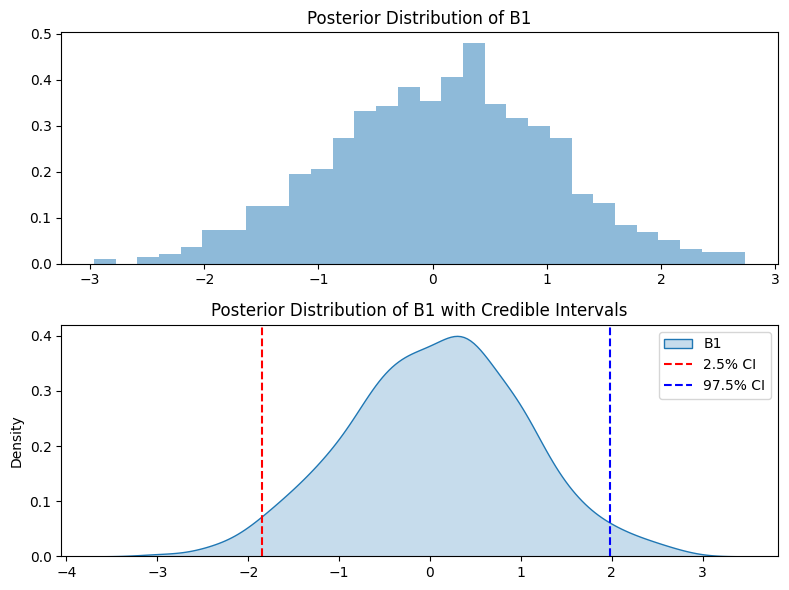

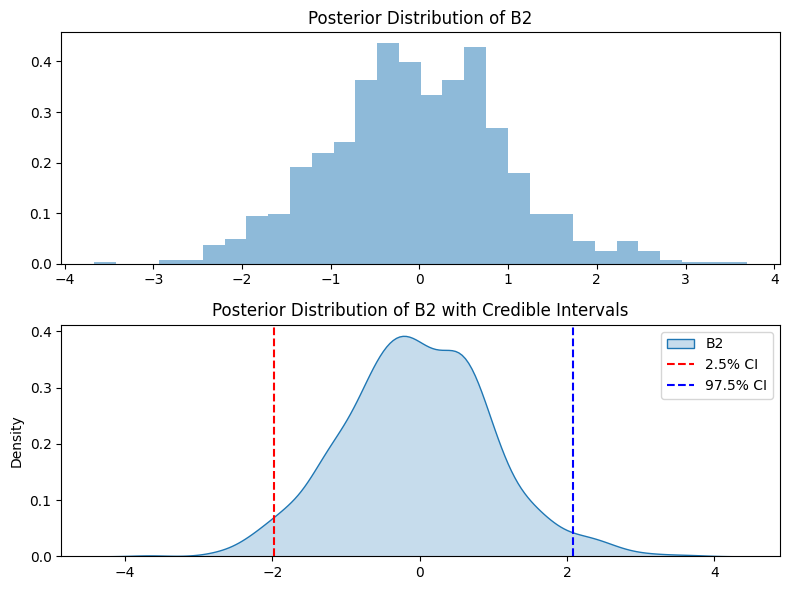

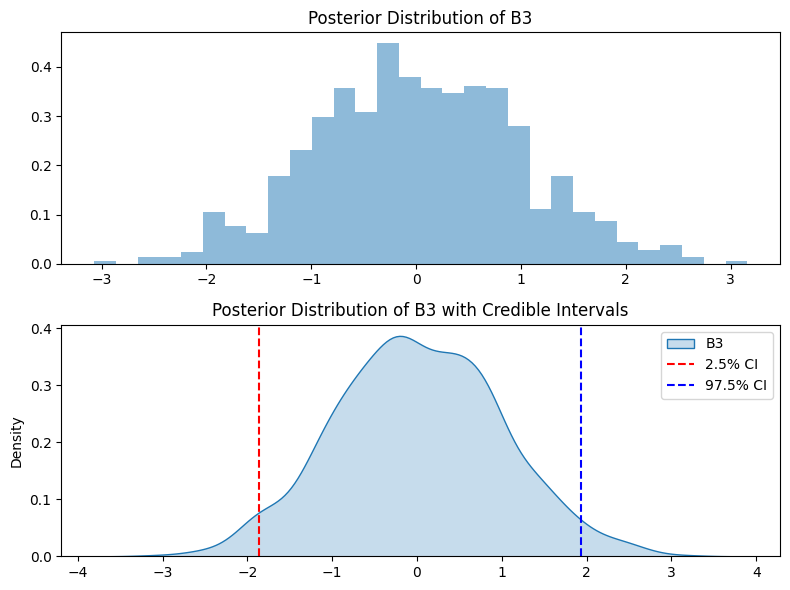

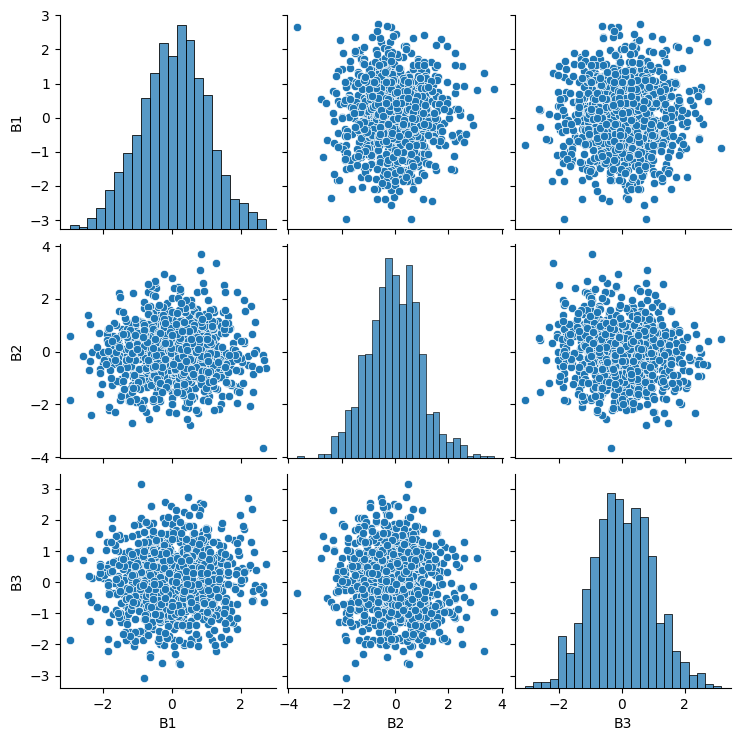

In [ ]:
# Print summary statistics
mean_samples = np.mean(posterior_samples, axis=0)
std_samples = np.std(posterior_samples, axis=0)
quantiles = np.percentile(posterior_samples, [2.5, 97.5], axis=0)

print("Mean:", mean_samples)
print("Standard Deviation:", std_samples)
print("95% Credible Interval:", quantiles)

# Plot histograms and credible intervals
for i in range(posterior_samples.shape[1]):
    plt.figure(figsize=(8, 6))

    # Histogram
    plt.subplot(2, 1, 1)
    plt.hist(posterior_samples[:, i], bins=30, density=True, alpha=0.5, label=f'B{i+1}')
    plt.title(f'Posterior Distribution of B{i+1}')

    # KDE and Credible Intervals
    plt.subplot(2, 1, 2)
    sns.kdeplot(posterior_samples[:, i], fill=True, label=f'B{i+1}')
    plt.axvline(quantiles[0, i], color='red', linestyle='--', label='2.5% CI')
    plt.axvline(quantiles[1, i], color='blue', linestyle='--', label='97.5% CI')
    plt.title(f'Posterior Distribution of B{i+1} with Credible Intervals')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Pair plot
import pandas as pd

samples_df = pd.DataFrame(posterior_samples, columns=['B1', 'B2', 'B3'])
sns.pairplot(samples_df)
plt.show()

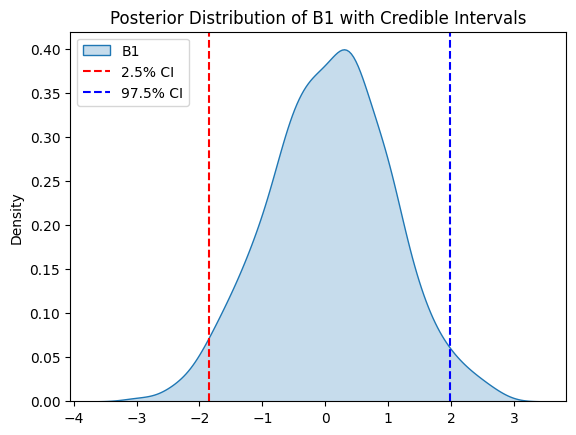

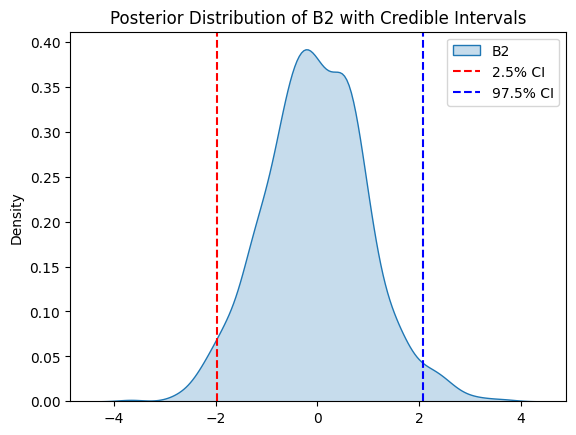

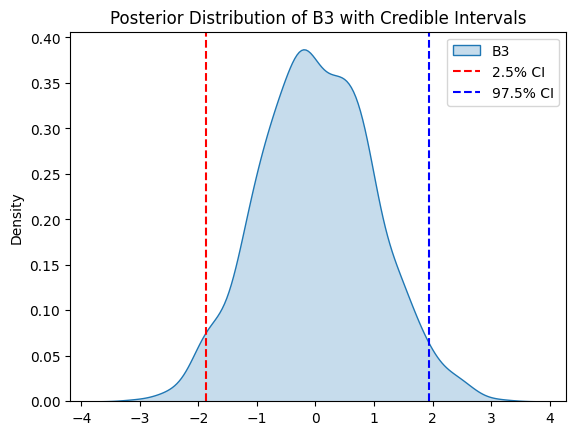

In [ ]:
import seaborn as sns
quantiles = np.percentile(posterior_samples, [2.5, 97.5], axis=0)

for i in range(posterior_samples.shape[1]):
    sns.kdeplot(posterior_samples[:, i], fill=True, label=f'B{i+1}')
    plt.axvline(quantiles[0, i], color='red', linestyle='--', label='2.5% CI')
    plt.axvline(quantiles[1, i], color='blue', linestyle='--', label='97.5% CI')
    plt.title(f'Posterior Distribution of B{i+1} with Credible Intervals')
    plt.legend()
    plt.show()


In [ ]:
import numpy as np
import arviz as az

# Calculate central tendency and spread
for param, posterior in zip(['B1', 'B2', 'B3'],
                             [posterior_B1, posterior_B2, posterior_B3]):
    print(f'Parameter: {param} Posterior')
    # Calculate the posterior probability that B1 > 0
    prob_positive = np.mean(posterior > 0)
    print(f'Effect on Accidents (1.0 Positive to 0.0 -> Negative) = {prob_positive}')
    print(f'Mean: {np.mean(posterior)}')
    print(f'Median: {np.median(posterior)}')
    print(f'Standard deviation: {np.std(posterior)}')
    print(f'Interquartile range: {np.percentile(posterior, 75) - np.percentile(posterior, 25)}')
    print("\n")


Parameter: B1 Posterior
Effect on Accidents (1.0 Positive to 0.0 -> Negative) = 0.56
Mean: 0.1756737381219864
Median: 0.14479224383831024
Standard deviation: 1.03347909450531
Interquartile range: 1.3632658869028091


Parameter: B2 Posterior
Effect on Accidents (1.0 Positive to 0.0 -> Negative) = 0.5044444444444445
Mean: 5.62337158564161e-06
Median: 6.334585317296868e-06
Standard deviation: 0.00026982959376700607
Interquartile range: 0.0003754271059697741


Parameter: B3 Posterior
Effect on Accidents (1.0 Positive to 0.0 -> Negative) = 0.5766666666666667
Mean: 2.7350132733917572e-06
Median: 1.1096929669754101e-05
Standard deviation: 6.405233217248062e-05
Interquartile range: 6.901099954962191e-05




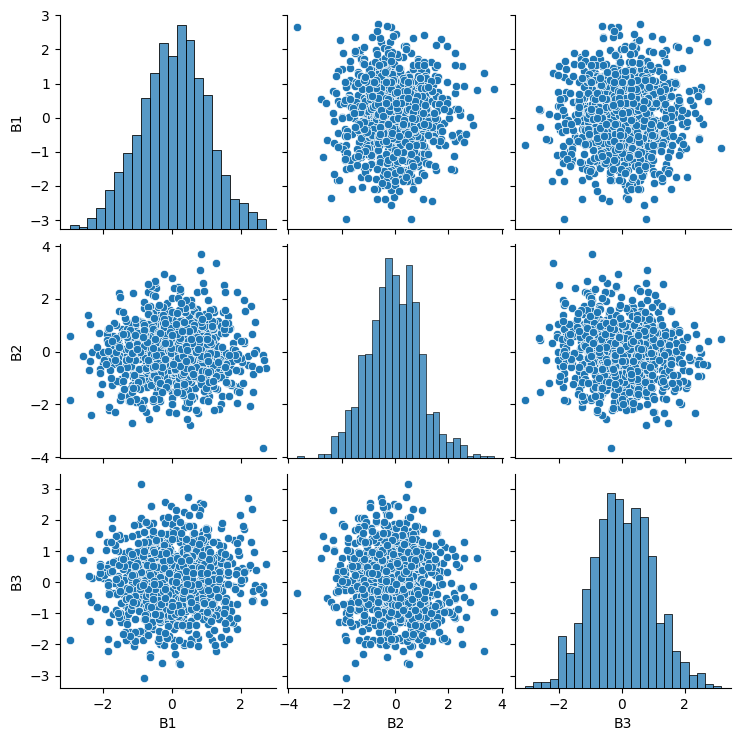

In [ ]:
samples_df = pd.DataFrame(posterior_samples, columns=['B1', 'B2', 'B3'])
sns.pairplot(samples_df)
plt.savefig('snsPosteriors.pdf')
plt.show()

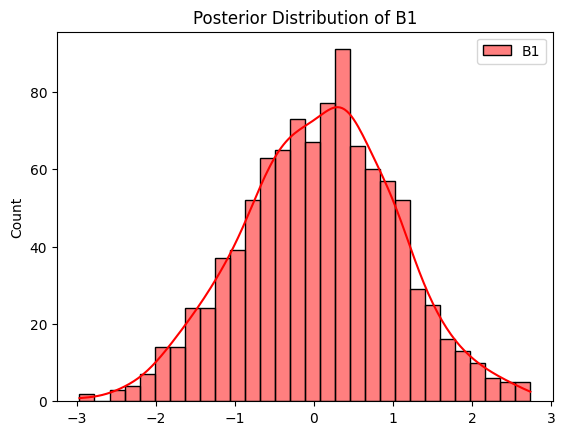

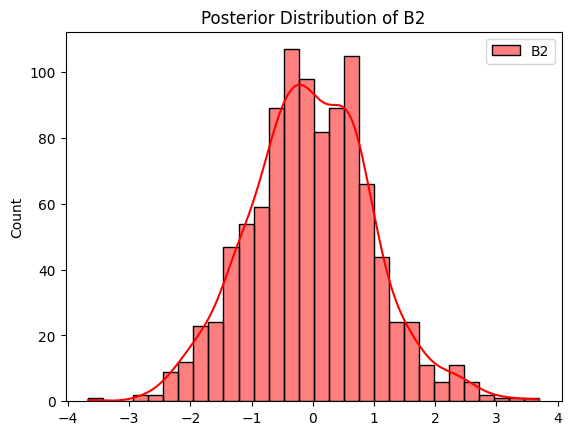

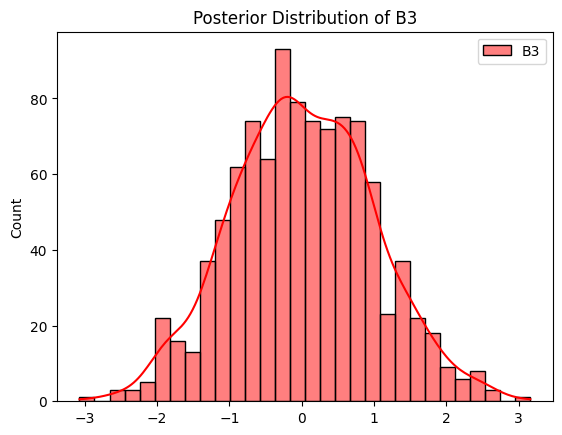

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming posterior_samples is a 2D NumPy array
for i in range(posterior_samples.shape[1]):
    sns.histplot(posterior_samples[:, i], bins=30, kde=True, label=f'B{i+1}', color='red')
    plt.title(f'Posterior Distribution of B{i+1}')
    plt.legend()
    plt.savefig(f'snsSingle_{i+1}.pdf')
    plt.show()

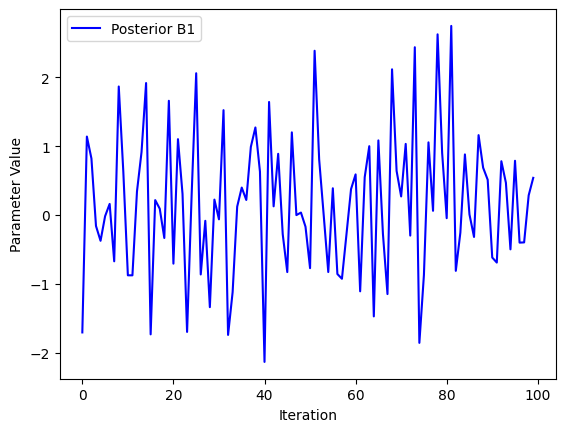

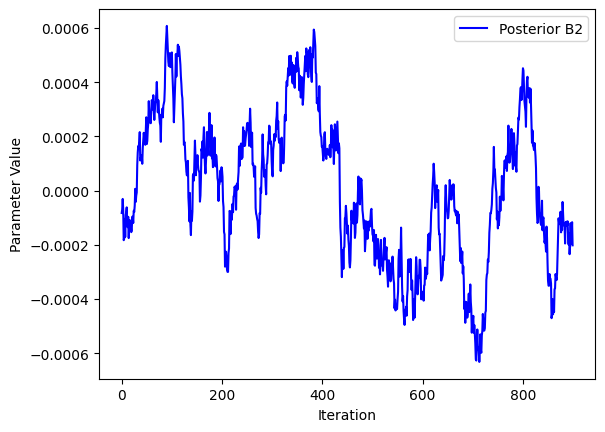

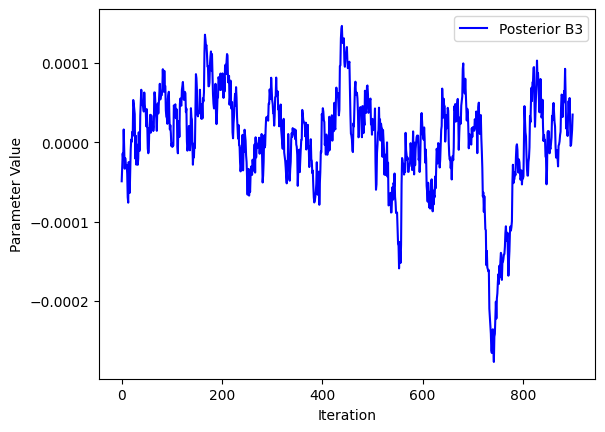

In [ ]:
# Plot trace plot for B1
plt.plot(posterior_B1, color='blue', label='Posterior B1')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()

# Plot trace plot for B2
plt.plot(posterior_B2, color='blue', label='Posterior B2')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()

# Plot trace plot for B3
plt.plot(posterior_B3, color='blue', label='Posterior B3')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()

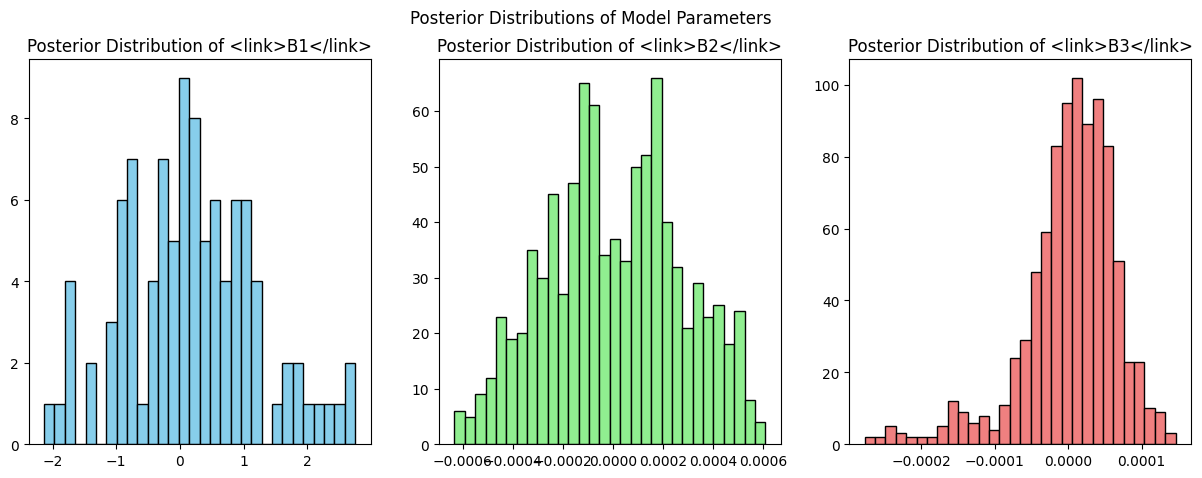

In [ ]:
# Create subplots for each parameter
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for the posterior distributions of <link>B1</link>, <link>B2</link>, and <link>B3</link>
axs[0].hist(posterior_B1, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Posterior Distribution of <link>B1</link>')
axs[1].hist(posterior_B2, bins=30, color='lightgreen', edgecolor='black')
axs[1].set_title('Posterior Distribution of <link>B2</link>')
axs[2].hist(posterior_B3, bins=30, color='lightcoral', edgecolor='black')
axs[2].set_title('Posterior Distribution of <link>B3</link>')

# Add labels and title
plt.suptitle('Posterior Distributions of Model Parameters')
plt.show()

# 9. ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


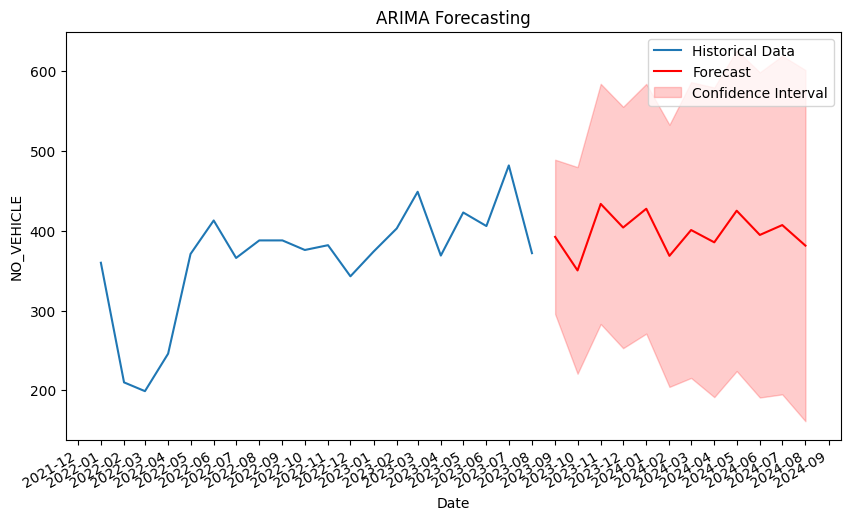

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load your data
filename = maxiInvData
data = pd.read_csv(filename)
data['YR_MTH'] = pd.to_datetime(data['YR_MTH'], format='%Y%m')

# Filter the data for rows where VEHICLE_CLASS_CODE is 3
filtered_data = data[data['VEHICLE_CLASS_CODE'] == 3]

# Filter the data to get only rows after '2022-01'
filtered_df = filtered_data[filtered_data['YR_MTH'] > '2021-12-01']

# Set 'YR_MTH' as the index
filtered_df.set_index('YR_MTH', inplace=True)

# Fit an ARIMA model
model = ARIMA(filtered_df['NO_VEHICLE'], order=(5, 1, 0))  # Adjust the order based on your data
results = model.fit()

# Forecast future values
future_steps = 12  # Number of months to forecast
forecast = results.get_forecast(steps=future_steps)

# Get forecast values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['NO_VEHICLE'], label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label='Confidence Interval')

# Format x-axis to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('NO_VEHICLE')
plt.title('ARIMA Forecasting')
plt.legend()
plt.show()


# 10. SARIMA

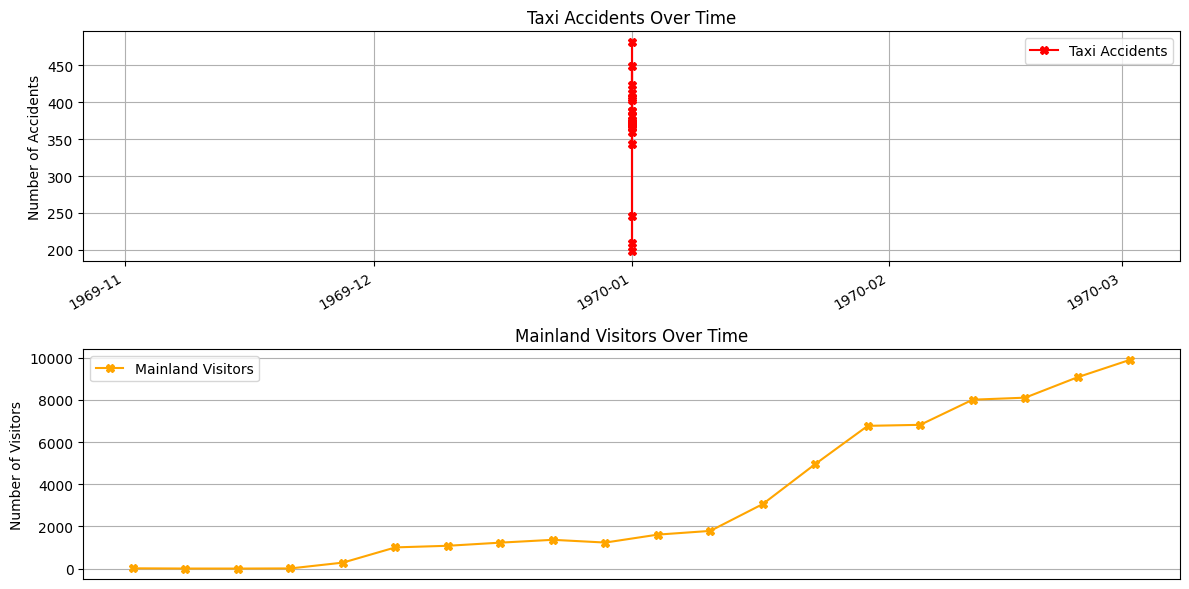

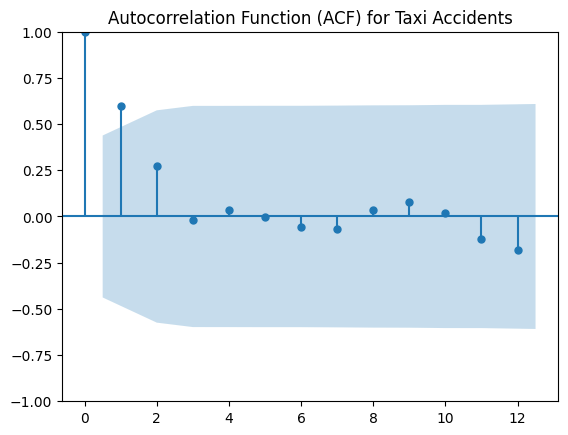

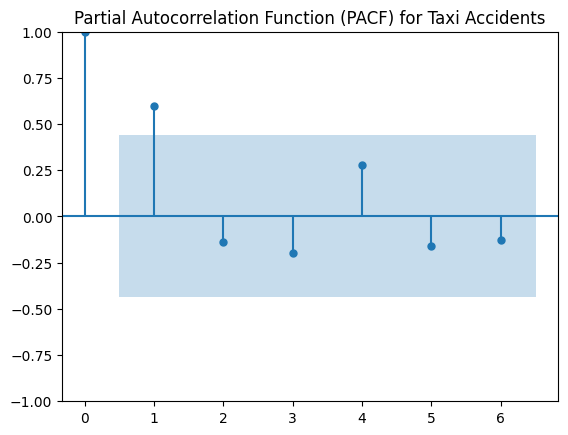

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to z

{'fopt': 2.125198763312386, 'gopt': array([ 1.96182626e-05,  8.88178419e-11, -6.95956626e-05,  2.50872612e-04,
       -4.51767068e-05]), 'fcalls': 804, 'warnflag': 1, 'converged': False, 'iterations': 100}


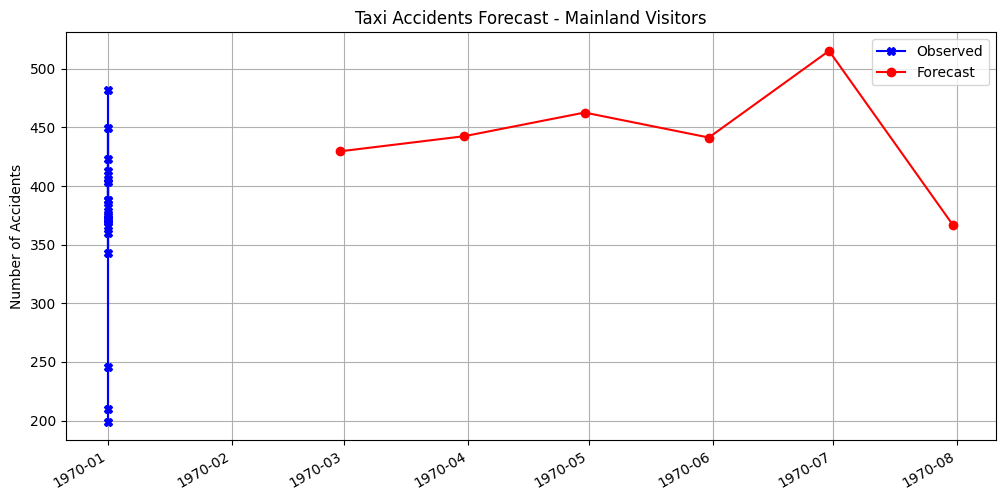

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the time series data for taxi accidents and Mainland Visitors
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(filtered_df_taxi['NO_VEHICLE'], label='Taxi Accidents', color='red', marker='X')
plt.title('Taxi Accidents Over Time')
plt.ylabel('Number of Accidents')

# Format x-axis to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()
plt.grid(True)

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(avg_arrivals_by_month_mainland['Mainland Visitors'], label='Mainland Visitors', color='orange', marker='X')
plt.title('Mainland Visitors Over Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert time index to datetime format
filtered_df_taxi.index = pd.to_datetime(filtered_df_taxi.index)
avg_arrivals_by_month_mainland.index = pd.to_datetime(avg_arrivals_by_month_mainland.index)

# Check autocorrelation and partial autocorrelation to determine the order of the SARIMA model
plot_acf(filtered_df_taxi['NO_VEHICLE'], lags=12)
plt.title('Autocorrelation Function (ACF) for Taxi Accidents')
plt.show()

plot_pacf(filtered_df_taxi['NO_VEHICLE'], lags=6)
plt.title('Partial Autocorrelation Function (PACF) for Taxi Accidents')
plt.show()


# Fit a SARIMA model for taxi accidents
# Example with specifying starting parameters
sarima_model = SARIMAX(filtered_df_taxi['NO_VEHICLE'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), start_params=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1])
sarima_result = sarima_model.fit(disp=False, maxiter=100)


print(sarima_result.mle_retvals)

# Forecast future values
forecast_steps = 6
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(filtered_df_taxi.index[-1], periods=forecast_steps + 1, freq='M')[1:]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df_taxi['NO_VEHICLE'], label='Observed',color='blue', marker='X')
plt.plot(forecast_index, forecast.predicted_mean, color='red', label='Forecast', marker='o')

# Format x-axis to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

plt.grid(True)

plt.title('Taxi Accidents Forecast - Mainland Visitors')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

# 11. Others

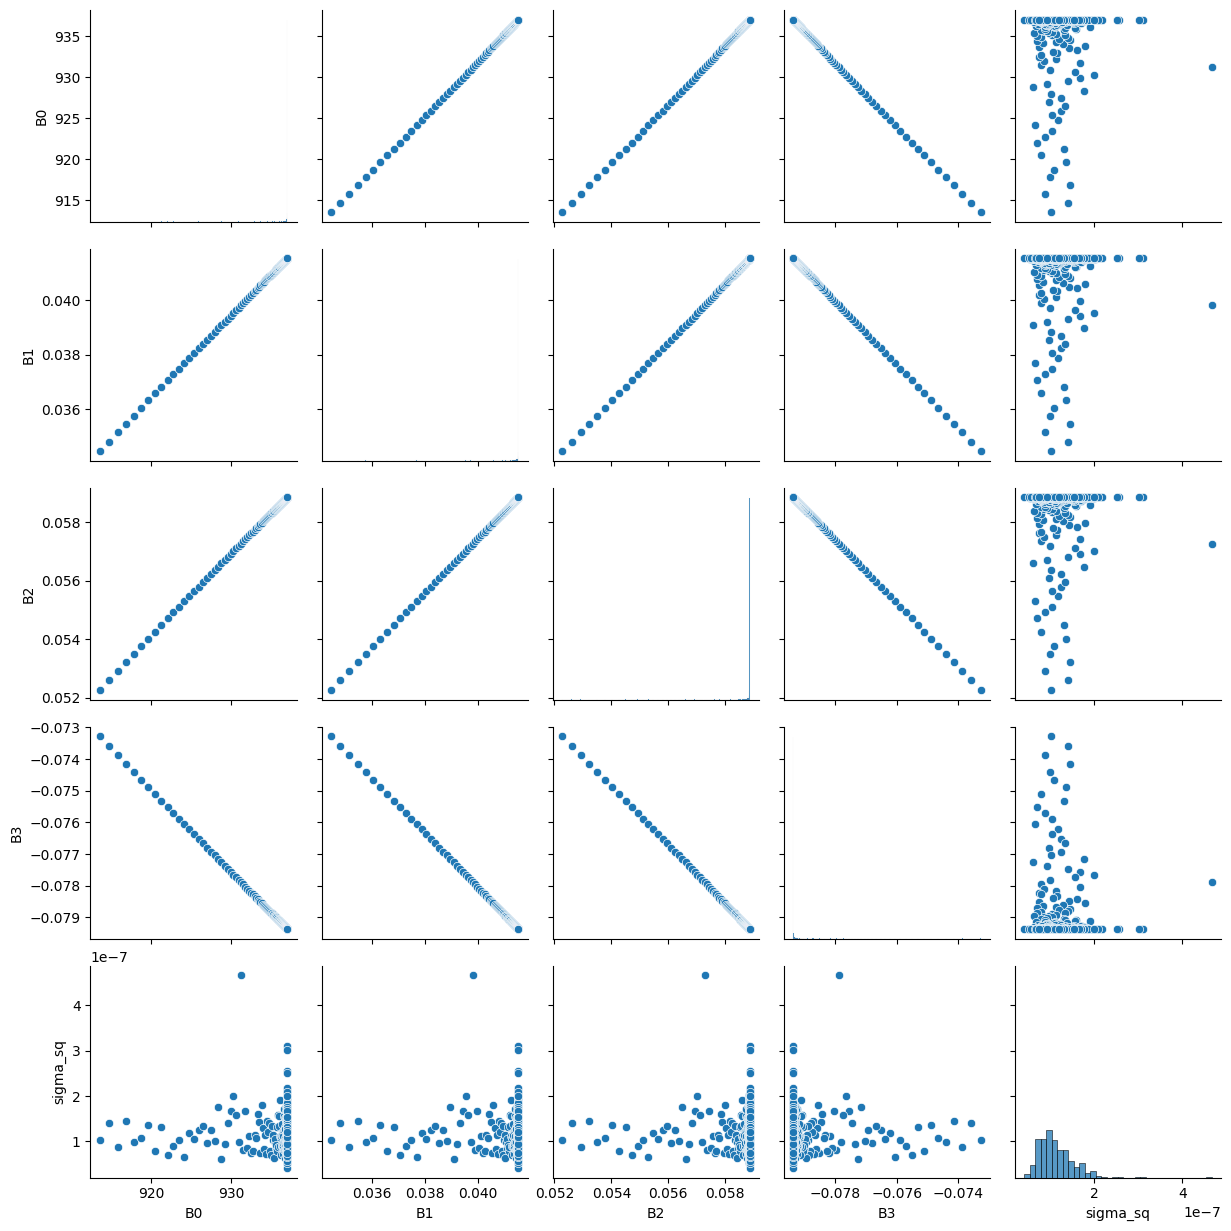

In [ ]:
df = pd.DataFrame({
    'B0': posterior_B0,
    'B1': posterior_B1,
    'B2': posterior_B2,
    'B3': posterior_B3,
    'sigma_sq': posterior_sigma_sq
})

# Create a pairwise plot
sns.pairplot(df)
plt.show()

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Convert NumPy arrays to PyTorch tensors
accidents_tensor = torch.tensor(accidents.values, dtype=torch.float32)
mainland_visitors_tensor = torch.tensor(mainland_visitors.values, dtype=torch.float32)
tourists_tensor = torch.tensor(tourists.values, dtype=torch.float32)
locals_tensor = torch.tensor(locals.values, dtype=torch.float32)

# Initialize the parameters as PyTorch tensors
B0 = torch.tensor(0.0, requires_grad=True)
B1 = torch.tensor(0.0, requires_grad=True)
B2 = torch.tensor(0.0, requires_grad=True)
B3 = torch.tensor(0.0, requires_grad=True)
sigma_sq = torch.tensor(1.0, requires_grad=True)

# Number of iterations
N_iter = 500

# Placeholder for the samples
samples = np.zeros((N_iter, 5))

# Define the model
def model(mainland_visitors, tourists, locals, accidents):
    sigma = pyro.sample("sigma", dist.HalfNormal(1.))
    mu = B0 + B1 * mainland_visitors + B2 * tourists + B3 * locals
    with pyro.plate("data", len(accidents)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=accidents)

# Define the guide (variational distribution)
def guide(mainland_visitors, tourists, locals, accidents):
    sigma_loc = pyro.param("sigma_loc", torch.tensor(1.), constraint=dist.constraints.positive)
    sigma = pyro.sample("sigma", dist.HalfNormal(sigma_loc))

# Set up the optimizer and inference algorithm
adam = Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

# Run the inference algorithm
num_steps = 1000
for step in range(num_steps):
    svi.step(mainland_visitors_tensor, tourists_tensor, locals_tensor, accidents_tensor)

# Extract the posterior mean of the parameters
B0_posterior_mean = pyro.param("B0_loc").item()
B1_posterior_mean = pyro.param("B1_loc").item()
B2_posterior_mean = pyro.param("B2_loc").item()
B3_posterior_mean = pyro.param("B3_loc").item()
sigma_posterior_mean = pyro.param("sigma_loc").item()

# Print or use the posterior means
print("B0 Posterior Mean:", B0_posterior_mean)
print("B1 Posterior Mean:", B1_posterior_mean)
print("B2 Posterior Mean:", B2_posterior_mean)
print("B3 Posterior Mean:", B3_posterior_mean)
print("Sigma Posterior Mean:", sigma_posterior_mean)


B0 Posterior Mean: 0.0
B1 Posterior Mean: 0.0
B2 Posterior Mean: 0.0
B3 Posterior Mean: 0.0
Sigma Posterior Mean: 1.3363335132598877


In [ ]:
# Convert to PyTorch tensors
accidents_tensor = torch.tensor(accidents.values, dtype=torch.float32)
mainland_visitors_tensor = torch.tensor(mainland_visitors.values, dtype=torch.float32)
tourists_tensor = torch.tensor(tourists.values, dtype=torch.float32)
locals_tensor = torch.tensor(locals.values, dtype=torch.float32)

In [ ]:
# Summary statistics
mean_B0 = np.mean(posterior_B0)
mean_B1 = np.mean(posterior_B1)
mean_B2 = np.mean(posterior_B2)
mean_B3 = np.mean(posterior_B3)
mean_sigma_sq = np.mean(posterior_sigma_sq)

credible_interval_95_B0 = np.percentile(posterior_B0, [2.5, 97.5])
credible_interval_95_B1 = np.percentile(posterior_B1, [2.5, 97.5])
credible_interval_95_B2 = np.percentile(posterior_B2, [2.5, 97.5])
credible_interval_95_B3 = np.percentile(posterior_B3, [2.5, 97.5])
credible_interval_95_sigma_sq = np.percentile(posterior_sigma_sq, [2.5, 97.5])

print("Mean B0:", mean_B0)
print("95% Credible Interval B0:", credible_interval_95_B0)
# Repeat for other parameters...


Mean B0: 707.7781202732244
95% Credible Interval B0: [651.09943201 716.92587098]


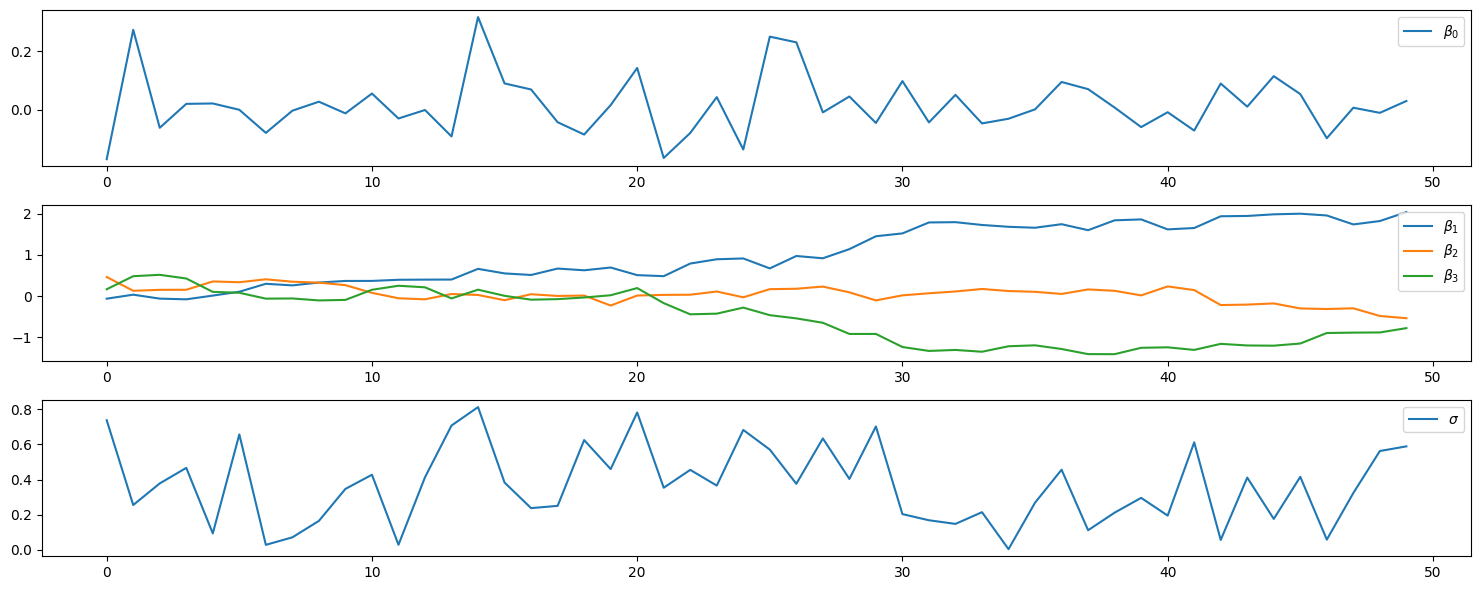

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
accidents_data = pd.DataFrame({
    'Mainland_Visitors': [14.225806451612904, 3.8214285714285716, 2.6129032258064515, 9.2, 284.8709677419355, 1007.4, 1084.1290322580646, 1232.8064516129032, 1366.8333333333333, 1236.741935483871, 1613.8333333333333, 1790.225806451613, 3063.4193548387098, 4961.357142857143, 6775.580645161291, 6823.433333333333, 8016.8387096774195, 8112.7, 9084.322580645161, 9910.612903225807],
    'Tourists': [483.2903225806452, 352.57142857142856, 276.4516129032258, 1396.3666666666666, 1879.4516129032259, 2267.4333333333334, 2761.9032258064517, 4062.6774193548385, 3425.1, 6203.0, 10171.9, 14434.935483870968, 20096.387096774193, 16396.60714285714, 18426.870967741936, 26153.8, 22432.09677419355, 25326.066666666666, 29118.74193548387, 33901.77419354839],
    'Locals': [14.580645161290322, 12.142857142857142, 8.774193548387096, 15.433333333333334, 105.06451612903226, 147.83333333333334, 169.38709677419354, 290.6774193548387, 414.8666666666667, 967.5483870967741, 1718.1666666666667, 2727.0, 3706.6129032258063, 7255.464285714285, 9119.322580645161, 11053.133333333333, 10138.774193548386, 12064.7, 11143.290322580646, 11089.41935483871],
    'Accidents': [360, 210, 199, 246, 371, 413, 366, 388, 388, 376, 382, 343, 374, 403, 449, 369, 423, 406, 482, 372]
})

# Normalize data for better convergence
accidents_data_norm = (accidents_data - accidents_data.mean()) / accidents_data.std()

# Gibbs Sampling
def gibbs_sampling(data, n_iter=1000):
    n = data.shape[0]
    p = data.shape[1] - 1  # Number of predictors

    # Initialize coefficients
    beta_0 = np.random.normal(0, 1)
    beta = np.random.normal(0, 1, size=p)
    sigma = np.random.uniform(0, 1)

    trace = np.zeros((n_iter, p + 2))
    for i in range(n_iter):
        # Update beta_0
        y_minus_Xbeta = data['Accidents'] - np.dot(data.drop('Accidents', axis=1), beta)
        beta_0 = np.random.normal(np.mean(y_minus_Xbeta), sigma / np.sqrt(n))

        # Update beta
        for j in range(p):
            X_j = data.iloc[:, j]
            y_minus_Xbeta_j = data['Accidents'] - (beta_0 + np.dot(data.drop(['Accidents', data.columns[j]], axis=1), np.delete(beta, j)))
            beta[j] = np.random.normal(np.dot(X_j, y_minus_Xbeta_j) / np.dot(X_j, X_j), sigma / np.sqrt(np.dot(X_j, X_j)))

        # Update sigma
        residuals = data['Accidents'] - (beta_0 + np.dot(data.drop('Accidents', axis=1), beta))
        sigma = np.random.uniform(0, np.std(residuals))

        trace[i, :] = np.concatenate(([beta_0], beta, [sigma]))

    return trace

# Run Gibbs Sampling
trace = gibbs_sampling(accidents_data_norm, n_iter=50)

# Plot trace
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.plot(trace[:, 0], label=r'$\beta_0$')
plt.legend()

plt.subplot(312)
plt.plot(trace[:, 1], label=r'$\beta_1$')
plt.plot(trace[:, 2], label=r'$\beta_2$')
plt.plot(trace[:, 3], label=r'$\beta_3$')
plt.legend()

plt.subplot(313)
plt.plot(trace[:, 4], label=r'$\sigma$')
plt.legend()

plt.tight_layout()
plt.show()


-MCMC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


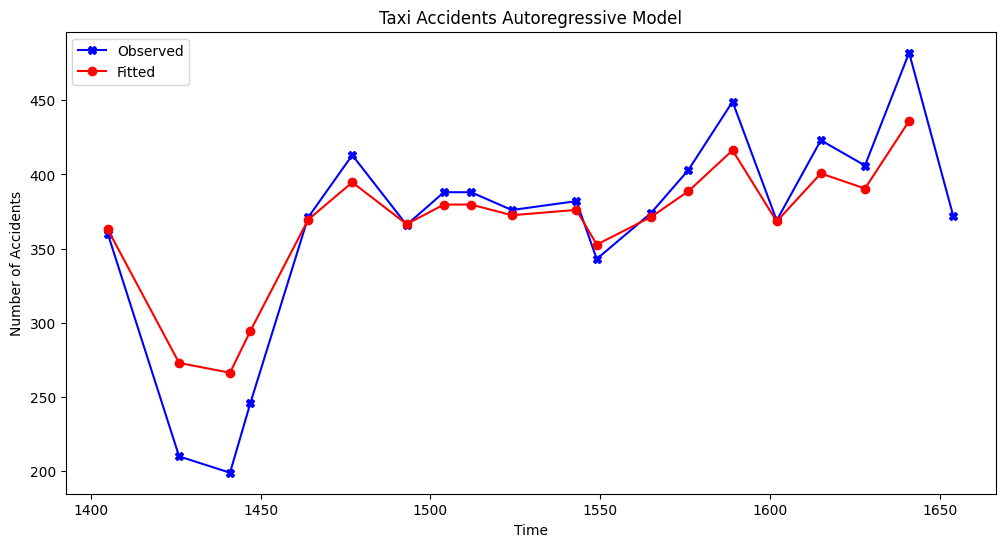

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will

InvalidIndexError: ignored

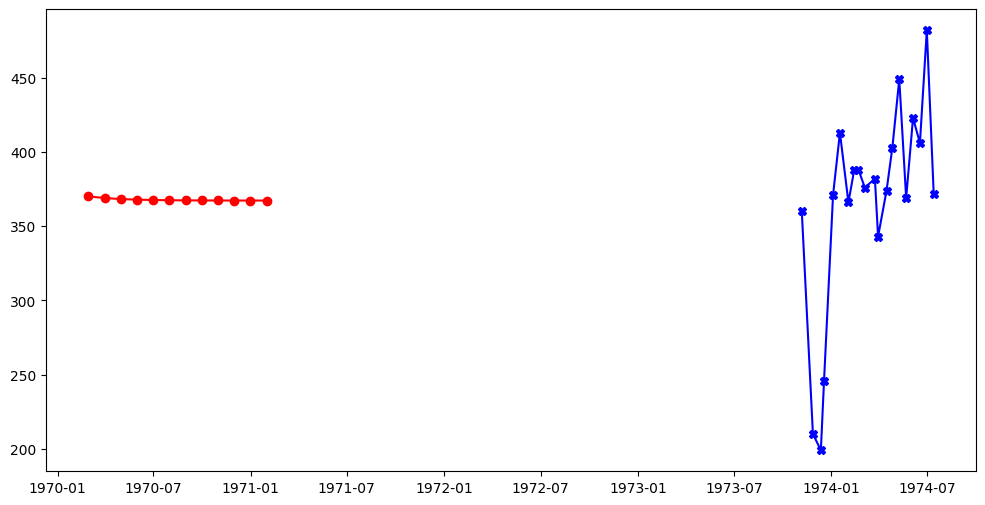

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

# Assuming 'filtered_df_taxi' is the DataFrame with time series data for taxi accidents
# Assuming 'DATE' is the datetime index

# Specify the lag order for autoregression
lag_order = 1  # You can adjust this based on the ACF and PACF analysis

# Fit autoregressive model
ar_model = AutoReg(filtered_df_taxi['NO_VEHICLE'], lags=lag_order)
ar_result = ar_model.fit()

# Plot the observed and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(filtered_df_taxi.index, filtered_df_taxi['NO_VEHICLE'], label='Observed', color='blue', marker='X')
plt.plot(filtered_df_taxi.index[:-lag_order], ar_result.fittedvalues, color='red', label='Fitted', marker='o')
plt.title('Taxi Accidents Autoregressive Model')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

# Forecast future values
forecast_steps = 12  # Change this as needed
forecast_index = pd.date_range(filtered_df_taxi.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast = ar_result.get_prediction(start=len(filtered_df_taxi), end=len(filtered_df_taxi) + forecast_steps - 1)

# Plot the original time series data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(filtered_df_taxi.index, filtered_df_taxi['NO_VEHICLE'], label='Observed', color='blue', marker='X')
plt.plot(forecast_index, forecast.predicted_mean, color='red', label='Forecast', marker='o')
plt.fill_between(forecast_index,
                 forecast.conf_int()[:, 0],
                 forecast.conf_int()[:, 1],
                 color='red', alpha=0.2)
plt.title('Taxi Accidents Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


Outcome - Mainland Visitors:
- fopt: 2.43898960272351
  - The optimal value of the objective function (the value being minimized during optimization). In the context of SARIMA model fitting, this represents the goodness of fit or the likelihood of the model given the data.

- gopt: '[-2.36728681e-04,  6.21724895e-10,  702726588e-04, -4.69159467e-04,-2.40707010e-05]'

  - The values of the gradient of the objective function at the optimal point. It gives information about the direction and magnitude of the change in the objective function with respect to changes in the model parameters.

- fcalls: 372
  - The number of function calls made during optimization. Each function call corresponds to evaluating the objective function at a specific point in the parameter space.

- warnflag: 1
  - A warning flag indicating if there were any issues during optimization. In this case, warnflag = 1 suggests a warning.

- converged: False
  - It did not converge.

- iterations: 50
